In [3]:
!pip install surprise

**----- Importing Necessary Liabraries -----**

In [4]:
import pandas as pd
import os
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise.model_selection import cross_validate
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from tqdm import tqdm
from surprise import accuracy

**----- Uploading Data -----**

In [5]:
# Function to load data with error handling
def load_data(file_path):
    try:
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")
        return pd.read_csv(file_path)
    except Exception as e:
        print(f"Error loading file: {e}")
        return None

# File paths
credits_path = "/content/credits.csv.zip"
keywords_path = "/content/keywords.csv.zip"
movies_path = "/content/movie.csv.zip"
ratings_path = "/content/ratings_small.csv.zip"

# Loading datasets
credit = load_data(credits_path)
keywords = load_data(keywords_path)
movie = load_data(movies_path)
rating = load_data(ratings_path)

# Verify
print("Data Succesfully Uploaded")

Data Succesfully Uploaded


**----- Checking Data -----**

In [6]:
# Checking all files shape and columns
print(credit.shape, credit.columns)
print(keywords.shape, keywords.columns)
print(movie.shape, movie.columns)
print(rating.shape, rating.columns)

(45476, 3) Index(['cast', 'crew', 'id'], dtype='object')
(46419, 2) Index(['id', 'keywords'], dtype='object')
(27278, 3) Index(['movieId', 'title', 'genres'], dtype='object')
(100004, 4) Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


**----- Preprocessing Columns one-by-one -----**

**----- Credit -----**

In [7]:
credit.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [8]:
credit.isnull().sum()

,0
cast,0
crew,0
id,0


In [9]:
def extract_top_cast(cast_column, top_n=3):
    try:
        cast_list = ast.literal_eval(cast_column)  # Parse the JSON-like string
        top_cast = [actor['name'] for actor in cast_list[:top_n]]  # Extract names
        return ' '.join(top_cast)
    except (ValueError, TypeError):
        return ''

credit["cast"] = credit["cast"].apply(lambda x: extract_top_cast(x))
credit["cast"]

,cast
0,Tom Hanks Tim Allen Don Rickles
1,Robin Williams Jonathan Hyde Kirsten Dunst
2,Walter Matthau Jack Lemmon Ann-Margret
3,Whitney Houston Angela Bassett Loretta Devine
4,Steve Martin Diane Keaton Martin Short
...,...
45471,Leila Hatami Kourosh Tahami Elham Korda
45472,Angel Aquino Perry Dizon Hazel Orencio
45473,Erika Eleniak Adam Baldwin Julie du Page
45474,Iwan Mosschuchin Nathalie Lissenko Pavel Pavlov


In [10]:
print(credit['cast'].str.split().str.len().describe())

count    45476.000000
mean         5.676225
std          1.608695
min          0.000000
25%          6.000000
50%          6.000000
75%          6.000000
max         13.000000
Name: cast, dtype: float64


In [11]:
def extract_director(crew_column):
    try:
        crew_list = ast.literal_eval(crew_column)  # Parse the JSON-like string
        for member in crew_list:
            if member['job'] == 'Director':
                return member['name']
        return ''
    except (ValueError, TypeError):
        return ''  # Handle missing or invalid data

credit["crew"] = credit["crew"].apply(lambda x: extract_director(x))

In [12]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   id      45476 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


**----- Keywords -----**

In [13]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [14]:
keywords.isnull().sum()

,0
id,0
keywords,0


In [15]:
def parse_keywords(x):
    try:
        return ' '.join([i['name'] for i in ast.literal_eval(x)]) if isinstance(x, str) else ''
    except (ValueError, SyntaxError):
        return ''

# Apply the function to the keywords column
keywords['keywords'] = keywords['keywords'].apply(parse_keywords)

In [16]:
keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        46419 non-null  int64 
 1   keywords  46419 non-null  object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB


**----- Movie -----**

In [17]:
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [18]:
movie.isnull().sum()

,0
movieId,0
title,0
genres,0


In [19]:
movie['genres'] = movie['genres'].apply(lambda x: x.replace('|', ' ') if isinstance(x, str) else '')
movie['genres'].value_counts().head()

,count
genres,
Drama,4520
Comedy,2294
Documentary,1942
Comedy Drama,1264
Drama Romance,1075


In [20]:
movie = movie.rename(columns={'movieId': 'id'})
movie = movie.merge(keywords, on='id').merge(credit, on='id')
movie.head()

,id,title,genres,keywords,cast,crew
0,2,Jumanji (1995),Adventure Children Fantasy,underdog prison factory worker prisoner helsin...,Turo Pajala Susanna Haavisto Matti Pellonpää,Aki Kaurismäki
1,3,Grumpier Old Men (1995),Comedy Romance,salesclerk helsinki garbage independent film,Matti Pellonpää Kati Outinen Sakari Kuosmanen,Aki Kaurismäki
2,5,Father of the Bride Part II (1995),Comedy,hotel new year's eve witch bet hotel room sper...,Tim Roth Antonio Banderas Jennifer Beals,Allison Anders
3,6,Heat (1995),Action Crime Thriller,chicago drug dealer boxing match escape one night,Emilio Estevez Cuba Gooding Jr. Denis Leary,Stephen Hopkins
4,11,"American President, The (1995)",Comedy Drama Romance,android galaxy hermit death star lightsaber je...,Mark Hamill Harrison Ford Carrie Fisher,George Lucas


In [21]:
movie.describe()

,id
count,6457.000000
mean,38754.842342
std,39877.367777
min,2.000000
25%,2993.000000
50%,26702.000000
75%,72483.000000
max,131172.000000


**----- Rating -----**

In [22]:
rating.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [23]:
rating.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0


In [24]:
# Normalize ratings
scaler = MinMaxScaler()
rating['normalized_rating'] = scaler.fit_transform(rating[['rating']])
rating = rating.drop(columns=["rating"], axis=1)
rating.head()

,userId,movieId,timestamp,normalized_rating
0,1,31,1260759144,0.444444
1,1,1029,1260759179,0.555556
2,1,1061,1260759182,0.555556
3,1,1129,1260759185,0.333333
4,1,1172,1260759205,0.777778


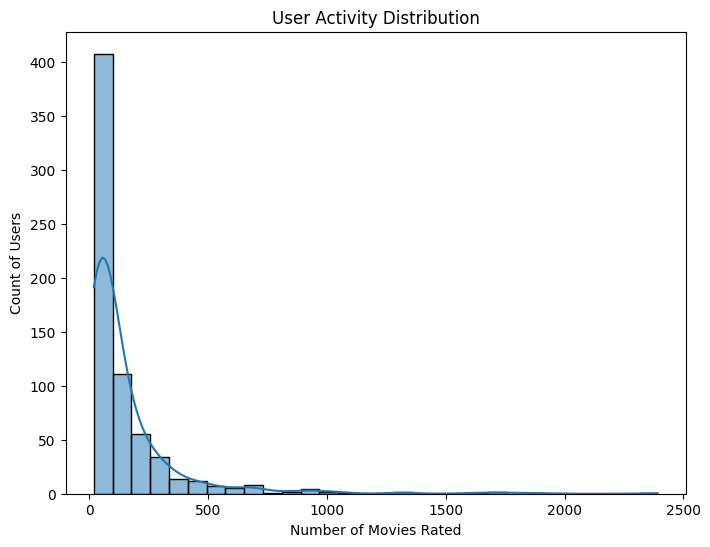

In [25]:
user_activity = rating.groupby('userId').size().reset_index(name='activity_count')
plt.figure(figsize=(8, 6))
sns.histplot(user_activity['activity_count'], bins=30, kde=True)
plt.title('User Activity Distribution')
plt.xlabel('Number of Movies Rated')
plt.ylabel('Count of Users')
plt.show()

**----- Filtering UserId and MovieId -----**

In [26]:
# Filter sparse movies
movie_ratings_count = rating.groupby('movieId').size()
sparse_movies = movie_ratings_count[movie_ratings_count < 10].index
movie = movie[~movie['id'].isin(sparse_movies)]
print(f"Remaining movies: {len(movie)}")

Remaining movies: 4581


In [27]:
# Count the number of ratings per user
user_ratings_count = rating.groupby('userId').size()

# Filter users with at least 10 ratings
active_users = user_ratings_count[user_ratings_count >= 10].index
rating = rating[rating['userId'].isin(active_users)]
print(f"Filtered ratings shape: {rating.shape}")

Filtered ratings shape: (100004, 4)


In [28]:
# Count the number of ratings per movie
movie_ratings_count = rating.groupby('movieId').size()

# Filter movies with at least 5 ratings
popular_movies = movie_ratings_count[movie_ratings_count >= 5].index
rating = rating[rating['movieId'].isin(popular_movies)]
print(f"Filtered ratings shape: {rating.shape}")

Filtered ratings shape: (90072, 4)


In [29]:
print(rating['userId'].nunique(), "unique users after filtering")
print(rating['movieId'].nunique(), "unique movies after filtering")

671 unique users after filtering
3496 unique movies after filtering


**----- Creating Soup Column -----**

In [30]:
movie['soup'] = movie['title'] + ' ' + movie['genres'] + ' ' + movie['keywords'] + ' ' + movie['cast']
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movie['soup'])
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

TF-IDF matrix shape: (4581, 18845)


**----- Content Recommendation System -----**

In [31]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [32]:
def get_content_recommendations(title, cosine_sim=cosine_sim):
    indices = pd.Series(movie.index, index=movie['title']).drop_duplicates()
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return movie['title'].iloc[movie_indices]

In [33]:
# Load dataset
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(rating[['userId', 'movieId', 'normalized_rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# SVD model
svd = SVD()
svd.fit(trainset)
predictions = svd.test(testset)

# Evaluate the model
baseline_rmse = accuracy.rmse(predictions)

RMSE: 0.2034


In [34]:
# Define parameter grid
param_grid = {
    'n_epochs': [5, 10],        # Number of training epochs
    'lr_all': [0.002, 0.005],   # Learning rate for all parameters
    'reg_all': [0.4, 0.6]       # Regularization term for all parameters
}

# Perform grid search
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=2)
grid_search.fit(data)

# Retrieve best RMSE and parameters
gridsearch_rmse = grid_search.best_score['rmse']
gridsearch_params = grid_search.best_params['rmse']

# Print results
print(f"Grid RMSE: {gridsearch_rmse:.4f}")
print(f"Grid Parameters: {gridsearch_params}")

Grid RMSE: 0.2023
Grid Parameters: {'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [35]:
print(f"Baseline SVD RMSE: {baseline_rmse}")
print(f"GridSearchCV Best RMSE: {gridsearch_rmse}")

Baseline SVD RMSE: 0.2034013701816199
GridSearchCV Best RMSE: 0.2023385051223119


Unique labels in y_true: [False  True]
Unique labels in y_pred: [False  True]
Confusion Matrix:
[[  886  2174]
 [  782 14173]]


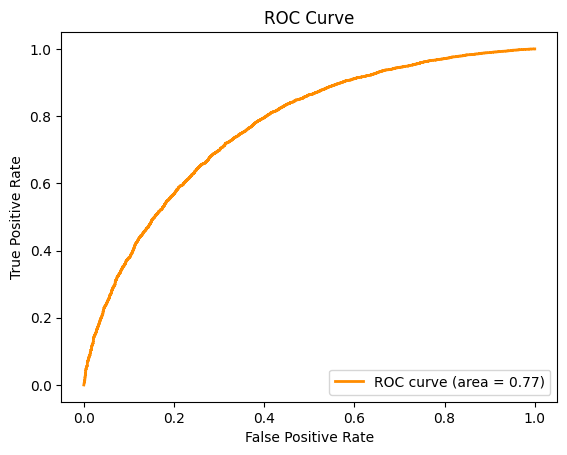

In [36]:
# Convert predictions to binary
y_true = [rating >= 0.5 for _, _, rating in testset]  # True labels
y_pred = [pred.est >= 0.5 for pred in predictions]  # Predicted labels

print("Unique labels in y_true:", np.unique(y_true))
print("Unique labels in y_pred:", np.unique(y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(f"Confusion Matrix:\n{cm}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, [pred.est for pred in predictions])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

**----- Hybrid Recommendation System & Combining Both-----**

In [37]:
def hybrid_recommendations(user_id, title, svd_model, cosine_sim, ratings):
    # Get content-based recommendations
    content_recs = get_content_recommendations(title, cosine_sim)

    # Get collaborative filtering recommendations
    user_ratings = ratings[ratings['userId'] == user_id]
    user_rated_movies = user_ratings['movieId'].values
    collaborative_recs = []
    for movie_id in user_rated_movies:
        prediction = svd_model.predict(user_id, movie_id)
        collaborative_recs.append((movie_id, prediction.est))

    collaborative_recs = sorted(collaborative_recs, key=lambda x: x[1], reverse=True)
    collaborative_recs = [x[0] for x in collaborative_recs[:10]]

    return list(set(content_recs) | set(collaborative_recs))

In [38]:
from surprise import accuracy

# Calculate RMSE
rmse = accuracy.rmse(predictions)

# Calculate MSE
mse = accuracy.mse(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Squared Error (MSE): {mse}")

RMSE: 0.2034
MSE: 0.0414
Root Mean Squared Error (RMSE): 0.2034013701816199
Mean Squared Error (MSE): 0.041372117391760374


In [39]:
title = "Heat (1995)"
# Define a function to evaluate the hybrid system
def evaluate_hybrid(user_id, title, hybrid_model, ratings, threshold=0.8):
    # Actual movies (ground truth): Movies the user rated >= threshold
    actual = set(ratings[(ratings['userId'] == user_id) & (ratings['normalized_rating'] >= threshold)]['movieId'])

    # Predicted movies (recommended by the hybrid model)
    predicted = set(hybrid_model(user_id, title, svd, cosine_sim, ratings))

    # Convert to binary format for precision/recall
    y_true = [1 if movie_id in actual else 0 for movie_id in predicted]
    y_pred = [1] * len(predicted)  # All recommendations are "positive" by definition

    # Calculate metrics
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    return precision, recall, f1

# Initialize overall metrics
overall_precision, overall_recall, overall_f1 = 0, 0, 0

# Iterate through all user IDs with a progress bar
for user_id in tqdm(rating['userId'].unique(), desc="Processing Users"):
    p, r, f = evaluate_hybrid(user_id, title, hybrid_recommendations, rating)
    overall_precision += p
    overall_recall += r
    overall_f1 += f

# Calculate averages
num_users = len(rating['userId'].unique())
print(f"Average Precision: {overall_precision / num_users:.2f}")
print(f"Average Recall: {overall_recall / num_users:.2f}")
print(f"Average F1-Score: {overall_f1 / num_users:.2f}")

Processing Users: 100%|██████████| 671/671 [00:09<00:00, 67.98it/s]

Average Precision: 0.28
Average Recall: 0.98
Average F1-Score: 0.42
